In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline 

import os

In [2]:
PATH = '/home/albin/data2/personal/GL/my_repo/capstone/rsna/rsna-pneumonia-detection-challenge'

In [3]:
print(os.listdir(PATH))

['stage_2_train_images.zip', 'stage_2_test_images.zip', 'stage_2_train_images', 'stage_2_detailed_class_info.csv', 'stage_2_sample_submission.csv', 'stage_2_test_images', 'GCP Credits Request Link - RSNA.txt', 'stage_2_train_labels.csv']


## 1. Load Data

In [4]:
train_labels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv')
class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')

In [5]:
print("train lables shape:", train_labels_df.shape)
print("class info shape:", class_info_df.shape)

train lables shape: (30227, 6)
class info shape: (30227, 2)


In [6]:
train_labels_df.sample(5)

patientId      x      y  width  height  \
18899  b10b52da-84fd-4057-b675-330e46c53504    NaN    NaN    NaN     NaN   
16517  9fa98c4a-50fb-46e2-bbc9-67e9c177a088    NaN    NaN    NaN     NaN   
29999  2c9a388f-0042-4b88-b52b-ea0b21fb7960  511.0  470.0  118.0   127.0   
28815  feb8dd3e-ecfc-493f-9094-00331a043c7c  214.0  312.0  218.0   227.0   
11784  79914079-6550-43f4-b420-27f06251b5b1    NaN    NaN    NaN     NaN   

       Target  
18899       0  
16517       0  
29999       1  
28815       1  
11784       0

In [7]:
class_info_df.sample(5)

patientId                         class
13396  86e9848d-dd57-48b4-b016-5b1447fdbd58                  Lung Opacity
9257   65ffbc68-367f-469a-9246-9277b57bd615                        Normal
1297   14302d4e-57f0-481b-a5a4-2305eebb0bb6                        Normal
9645   692e6a56-4cd6-4500-8712-2e647c43bb1d  No Lung Opacity / Not Normal
4834   41b1ed65-5567-4e6d-8fa6-77d6ab8e1431  No Lung Opacity / Not Normal

#### In 'class detailed info dataset' are given the detailed information about the type of positive or negative class associated with a certain patient.

#### In 'train labels' dataset are given the patient ID and the window (x min, y min, width and height of the) containing evidence of pneumonia.

#### From the data its been observed that the data contain lots of missing data (NaN)

## 2. Data Exploration

### a. Identify the missing data


In [8]:
def count_missing_data(data_df):
    total = data_df.isnull().sum().sort_values(ascending = False)
    percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [9]:
count_missing_data(train_labels_df)

Total    Percent
height     20672  68.389188
width      20672  68.389188
y          20672  68.389188
x          20672  68.389188
Target         0   0.000000
patientId      0   0.000000

In [10]:
count_missing_data(class_info_df)

Total  Percent
class          0      0.0
patientId      0      0.0

### b. Check the class distribution from the class details

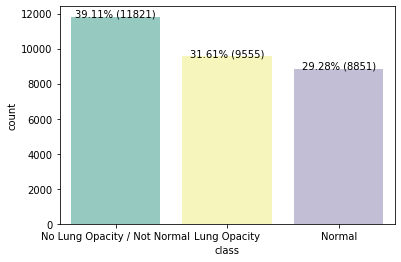

In [11]:
f, ax = plt.subplots(1,1, figsize=(6,4))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')

total = float(len(class_info_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}% ({:d})'.format(100*height/total, height),
            ha="center") 
plt.show()

In [12]:
### Merge train and class info details 

In [13]:
# Let's merge now the two datasets, using Patient ID as the merge criteria.
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')
train_class_df.sample(5)

patientId      x      y  width  height  \
30807  dc3f50d6-3e8c-4c5b-814b-3f2043165556  627.0  477.0  251.0   235.0   
29772  d462f0e8-9162-4588-ba30-ddc08e33ad3b    NaN    NaN    NaN     NaN   
22028  a9ac367b-4344-4cc4-8fb0-5de971f0ff1b    NaN    NaN    NaN     NaN   
35483  fd56515c-3b36-4750-bb62-8c8ebcc4747d    NaN    NaN    NaN     NaN   
21171  a445fa0d-51c8-4e5f-aac8-7f2e551c67c3  631.0   32.0  331.0   777.0   

       Target         class  
30807       1  Lung Opacity  
29772       0        Normal  
22028       0        Normal  
35483       0        Normal  
21171       1  Lung Opacity

In [14]:
### Density of target values vs classes

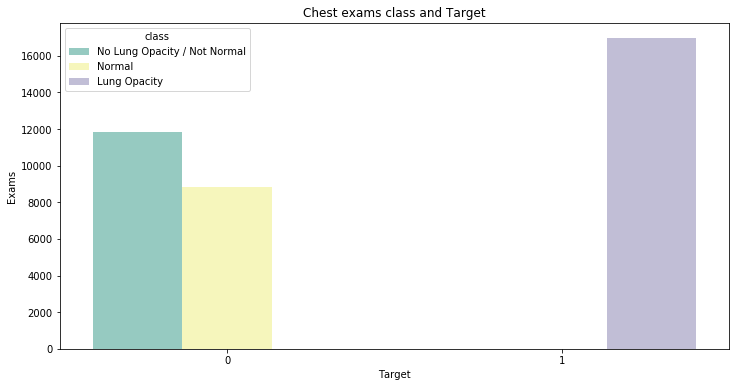

In [15]:
# Let's plot the number of examinations for each class detected, grouped by Target value.
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

#### All chest examinations withTarget = 1 (pathology detected) associated with class: Lung Opacity.

#### The chest examinations with Target = 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal.

In [16]:
### Analyze the lung opacity window

<Figure size 432x288 with 0 Axes>

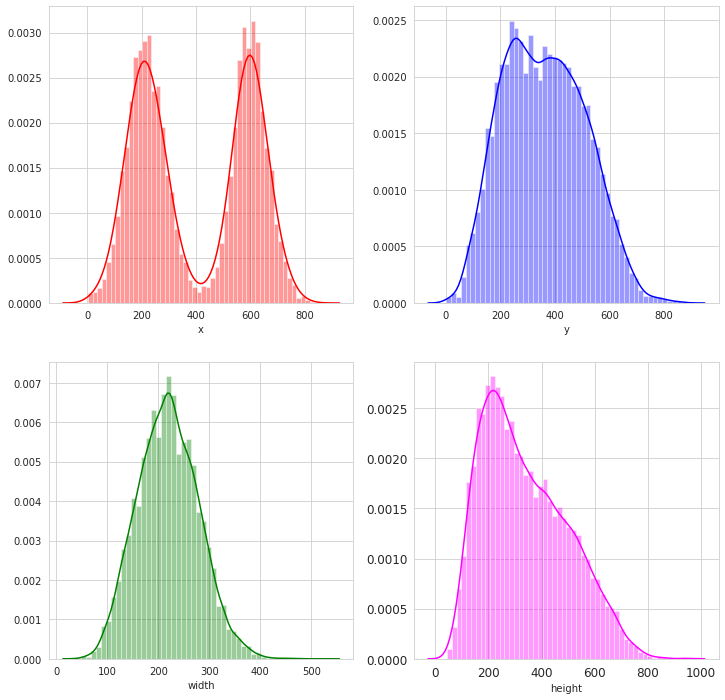

In [17]:
# For the class Lung Opacity, corresponding to values of Target = 1, we plot the density of x, y, width and height.
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

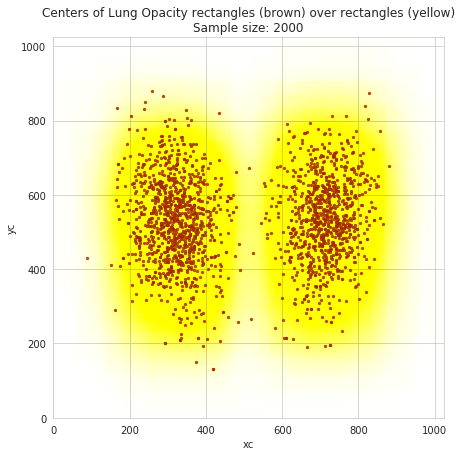

In [18]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

# 3. Explore DICOM data

In [19]:
# Read a sample of DICOM data
image_sample_path = os.listdir(PATH+'/stage_2_train_images')[:5]
print(image_sample_path)

['c2bb3e6e-0d98-4d61-bfd7-8a77fee603a2.dcm', '88a033e5-b48c-4f0c-aa0a-3c0ae353cc0d.dcm', '84a853f6-ae4d-432b-8adf-9e19c55064a3.dcm', '02475a31-ed48-4ff3-b401-5d74694bff8d.dcm', '3ce9825c-2910-4596-81e9-78d076c7fe52.dcm']


In [20]:
# Read the 'train' and 'test' image data
image_train_path = os.listdir(PATH+'/stage_2_train_images')
image_test_path = os.listdir(PATH+'/stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


In [21]:
# check for duplicate reconrds in training set
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique()) 

Unique patientId in  train_class_df:  26684


In [22]:
train_class_df.shape

(37629, 7)

#### But the total number of records are 37629. So we have to find out which all reconrds are duplicates

In [23]:
tmp = train_class_df.groupby(['patientId','Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams', 'Target','Class', 'Entries']
df2

Exams  Target                         Class  Entries
0      1       0  No Lung Opacity / Not Normal    11821
1      1       0                        Normal     8851
2      1       1                  Lung Opacity     2614
3      4       1                  Lung Opacity     3266
4      9       1                  Lung Opacity      119
5     16       1                  Lung Opacity       13

### Extract one image and process the DICOM information.

In [24]:
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join(PATH,"stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

#### Let's sample few images having the Target = 1.

##### Plot DICOM images with Target = 1

In [25]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

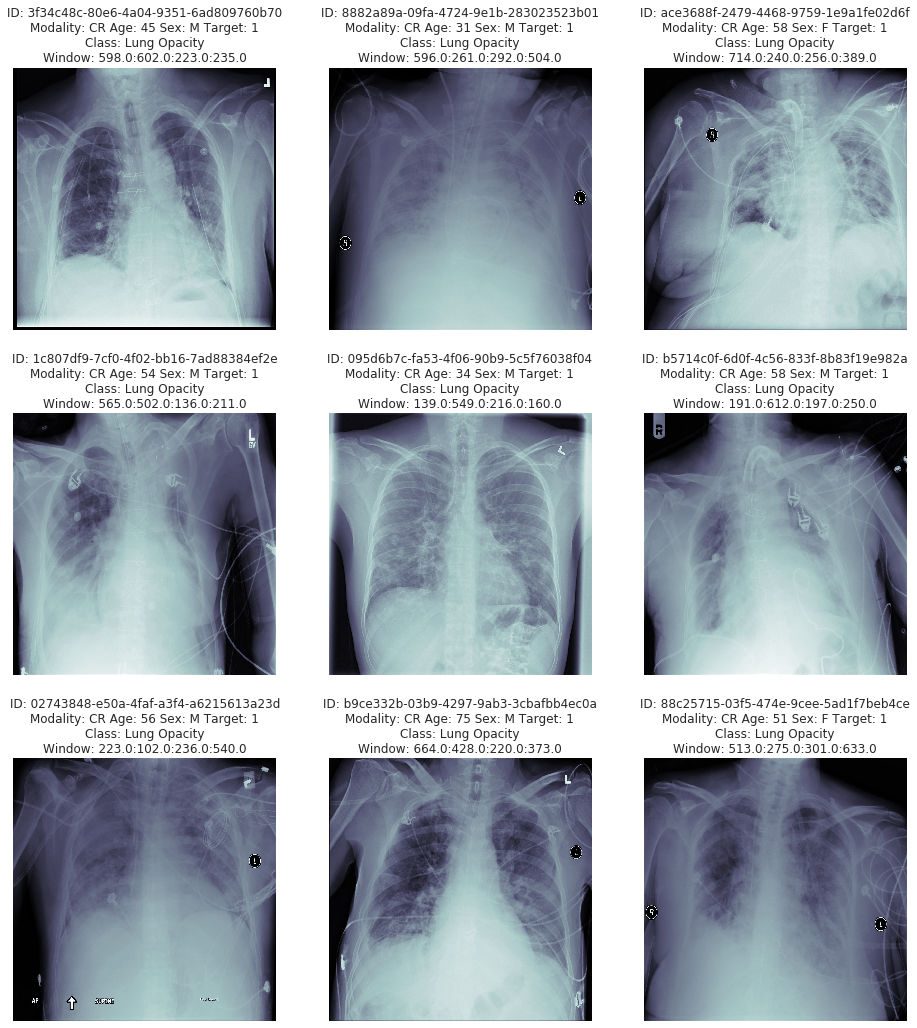

In [26]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

#### Plot DICOM images with Target = 1, with bounding boxes

In [27]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="blue",alpha = 0.1))   
    plt.show()

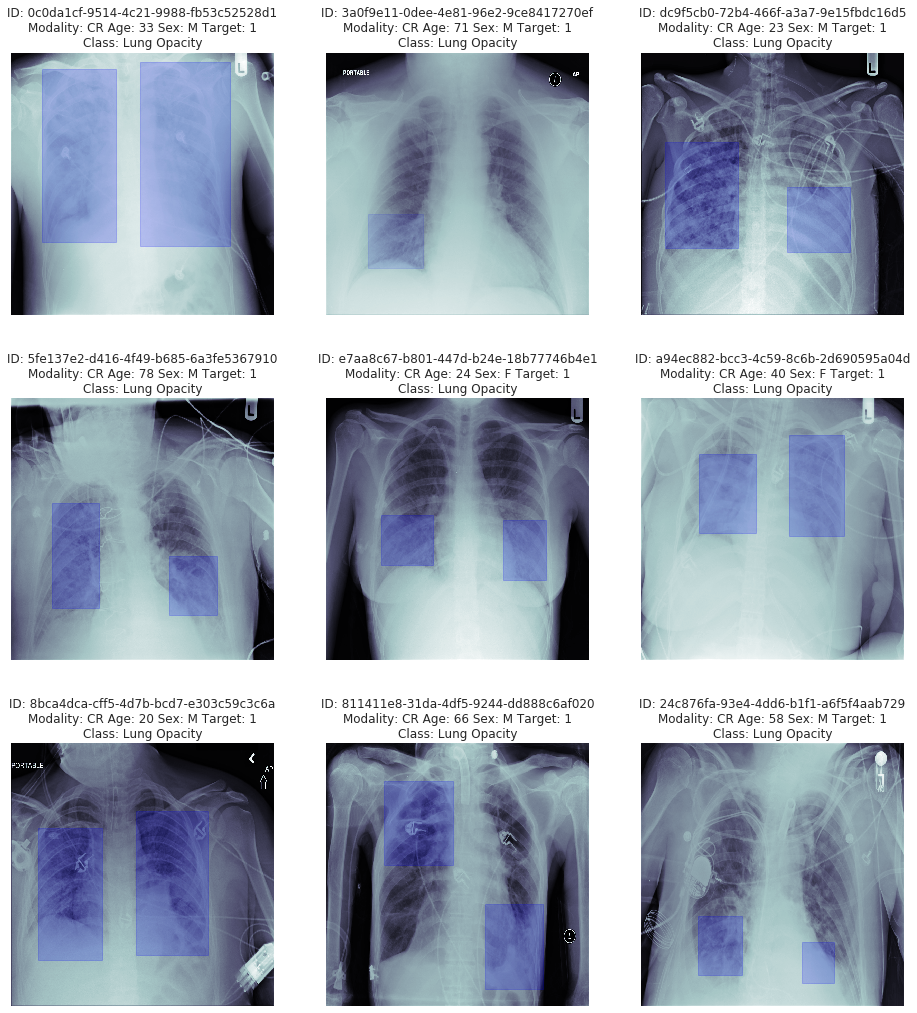

In [28]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

#### Plot DICOM images with Target = 0

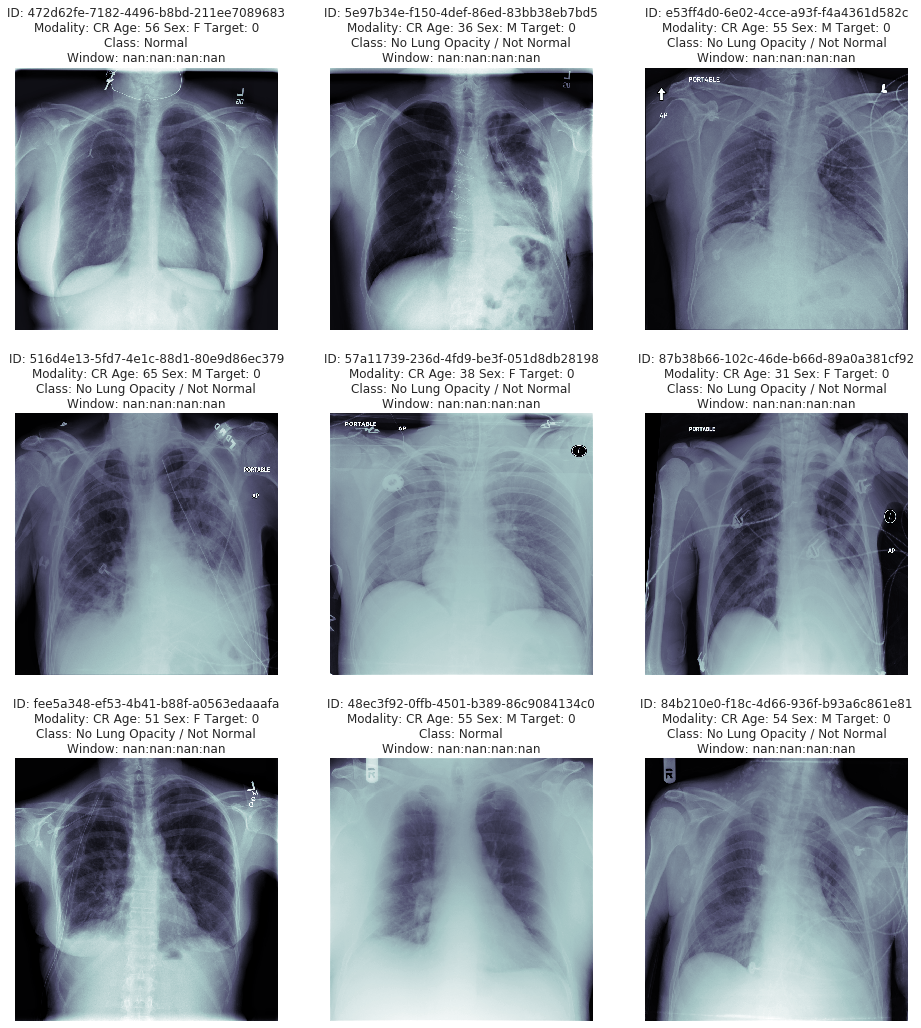

In [29]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(9))

## Build the model

In [30]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [31]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join(PATH+'/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]


In [32]:
# load and shuffle filenames
folder = PATH+'/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))


n train samples 24124
n valid samples 2560
Total train images: 26684
Images with pneumonia: 6012


In [33]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=128, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [34]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x


def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



In [35]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=128, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])
print("model summary:", model.summary())
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           batch_normalization_v1[0][0]     
_____________________________________

In [42]:

# create train and validation generators
folder = PATH+'/stage_2_train_images'
train_gen = generator(folder, train_filenames[0:500], pneumonia_locations, batch_size=16, image_size=128, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames[0:100], pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)

#history = model.fit_generator(train_gen, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)


Epoch 1/25
31/31 [==============================] - 14s 465ms/step - loss: 7.2625 - acc: 0.9719 - mean_iou: 0.7499 - val_loss: 7.8728 - val_acc: 0.9623 - val_mean_iou: 0.6669
Epoch 2/25
31/31 [==============================] - 12s 387ms/step - loss: 7.4746 - acc: 0.9677 - mean_iou: 0.7276 - val_loss: 7.2626 - val_acc: 0.9665 - val_mean_iou: 0.7109
Epoch 3/25
31/31 [==============================] - 13s 432ms/step - loss: 7.4308 - acc: 0.9733 - mean_iou: 0.7417 - val_loss: 7.5204 - val_acc: 0.9613 - val_mean_iou: 0.6432
Epoch 4/25
31/31 [==============================] - 12s 399ms/step - loss: 7.2214 - acc: 0.9734 - mean_iou: 0.7544 - val_loss: 7.6064 - val_acc: 0.9670 - val_mean_iou: 0.7247
Epoch 5/25
31/31 [==============================] - 12s 400ms/step - loss: 7.1419 - acc: 0.9734 - mean_iou: 0.7356 - val_loss: 8.2941 - val_acc: 0.9629 - val_mean_iou: 0.6954
Epoch 6/25
31/31 [==============================] - 12s 391ms/step - loss: 7.2543 - acc: 0.9726 - mean_iou: 0.7622 - val_loss

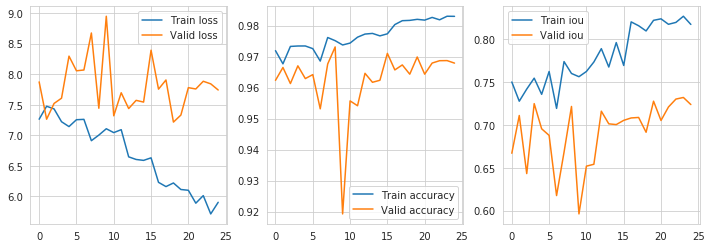

In [43]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

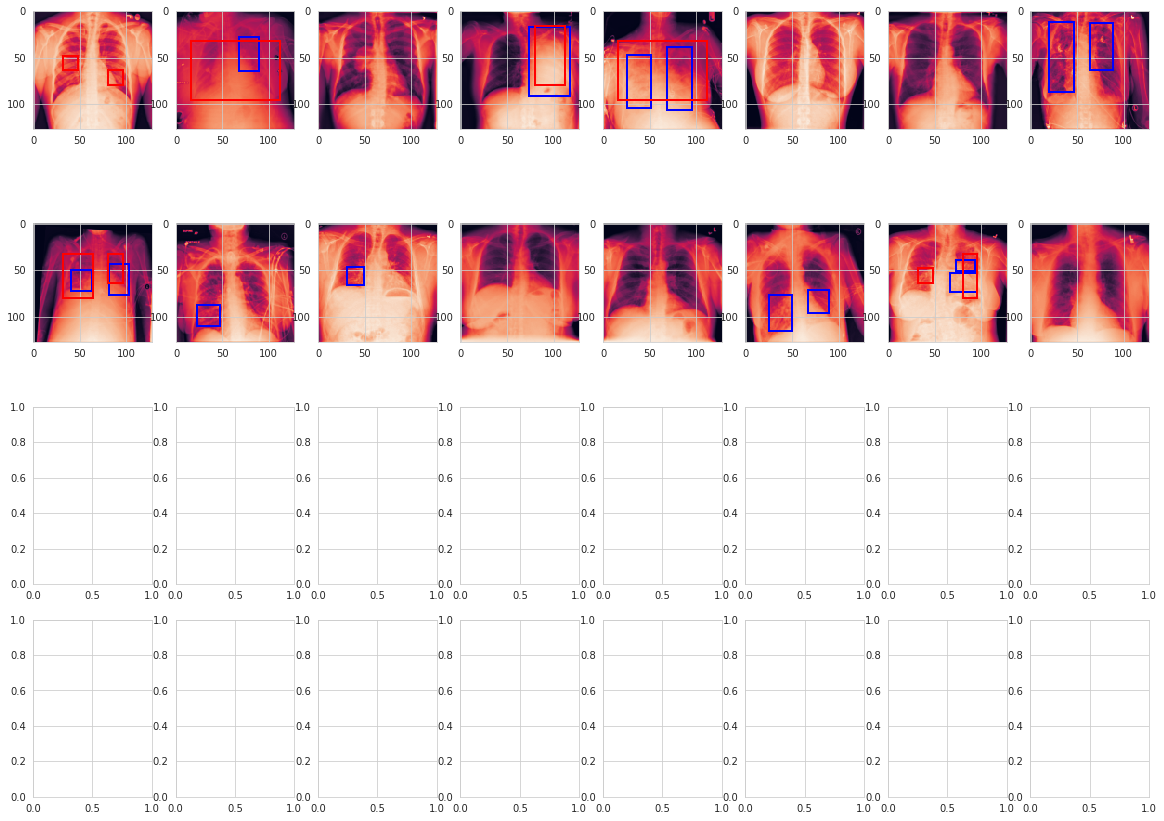

In [39]:


for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

